<a href="https://colab.research.google.com/github/melofton/PY-VERA_EXAMPLE/blob/main/Vera_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VERA forecasting challenge Python tutorial

**Authors**: Rohit Shukla, ...

**Date created:**

**Date last modified:**

Brief description of notebook (a few sentences summarizing its purpose and what it does)

Before we get started, we will load several Python libraries that are needed to complete the tutorial.

In [4]:
################ Load Python libraries ######################################################
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
from google.colab import drive
import requests
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="findfont: Font family.*")
from sklearn.linear_model import LinearRegression
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr, isinstalled
import seaborn as sns
import logging
from sklearn.metrics import r2_score
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
rpy2_logger.setLevel(logging.ERROR)

Next, we will also install a custom R package that has been specifically developed to assist users in submitting forecasts to the VERA challenge (`vera4casthelpers`), as well as a few R dependencies of that package. The first two lines of code (beginning with `!R -e`) should only be run once per session as they takes a few minutes to run, so you will need to uncomment those two lines to run them one time only.

We will also load the R packages for use later in the tutorial.

In [16]:
###############################################################################################
# R Packages installations 'Uncomment' if you haven't run it before in your session
# This will take a few minutes to run!
###############################################################################################

#!R -e "install.packages(c('reticulate','dplyr','arrow'), repos='http://cran.us.r-project.org')"
#!R -e "remotes::install_github('LTREB-reservoirs/vera4castHelpers')"

# Load required R packages
base = importr('base')
lubridate = importr('lubridate')
dplyr = importr('dplyr')
arrow = importr('arrow')
vera4castHelpers = importr('vera4castHelpers')


R version 4.5.0 (2025-04-11) -- "How About a Twenty-Six"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages(c('reticulate','dplyr','arrow'), repos='http://cran.us.r-project.org')
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘assertthat’

trying URL 'http://cran.us.r-project.org/src/contrib/RcppTOML_0.

Now, we will read in the "targets" data; this is the cleaned observational data from the focal reservoirs that we can use to train our forecasting models! More information on the targets data can be found at: https://www.ltreb-reservoirs.org/vera4cast/targets.html.

In [9]:
################ Reading and Visualizing the target variable ###################################

# Download and read targets data
targets_url = 'https://renc.osn.xsede.org/bio230121-bucket01/vera4cast/targets/project_id=vera4cast/duration=P1D/daily-insitu-targets.csv.gz'
targets_all = pd.read_csv(targets_url, compression='gzip')


We will also read in the site metadata for the two reservoir sites for which we can generate forecasts: Falling Creek Reservoir and Beaverdam Reservoir. Today, we will focus on generating a forecast for Falling Creek Reservoir (site code `fcre`) only.

In [7]:
# Read site metadata
site_meta_url = "https://raw.githubusercontent.com/LTREB-reservoirs/vera4cast/main/vera4cast_field_site_metadata.csv"
site_list = pd.read_csv(site_meta_url)

For the purposes of this tutorial, we will focus on generating a water temperature forecast at Falling Creek Reservoir. Here, we filter our targets data to only include daily mean water temperature collected at a depth of 1.6 meters, and then visualize this temperature data.

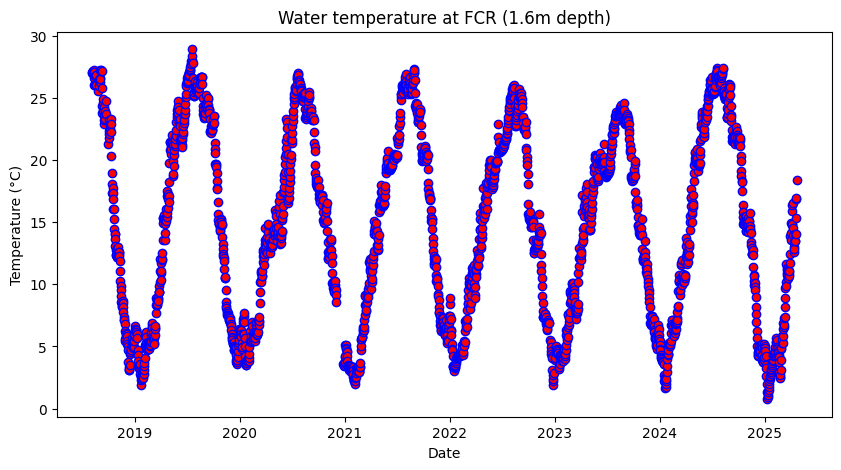

In [10]:
# Filter for Falling Creek Reservoir (fcre) and temperature data
site_list = site_list[site_list['site_id'] == 'fcre']
targets = targets_all[
    (targets_all['site_id'] == 'fcre') &
    (targets_all['variable'] == 'Temp_C_mean') &
    (targets_all['duration'] == 'P1D') &
    (targets_all['depth_m'] == 1.6)
]

# Visualize temperature data
plt.figure(figsize=(10, 5))
plt.scatter(pd.to_datetime(targets['datetime']), targets['observation'],color='#FF0000',edgecolor='blue')
plt.title('Water temperature at FCR (1.6m depth)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

While we will be focusing on water temperature today, there are *many* variables other than water temperature available for forecasting! Optionally, before moving ahead, take a few minutes to uncomment the lines below and visualize all the variables, or alter the code to focus on a variable of your choice.

In [ ]:
####  'Uncomment' to get variable names from the list of target variables.  #############

# unique_variables = targets_all['variable'].unique()

# # Print the unique variable names
# print("Unique Variable Names:")
# for variable_name in unique_variables:
#     print(variable_name)


# # Create subplots based on the number of variables
# fig, axes = plt.subplots(len(unique_variables), 1, figsize=(10, 5 * len(unique_variables)), sharex=True)

# # Iterate through unique variables and plot on respective subplots
# for i, variable_name in enumerate(unique_variables):
#     subset = targets[targets['variable'] == variable_name]
#     axes[i].scatter(pd.to_datetime(subset['datetime']), subset['observation'])
#     axes[i].set_title(f'{variable_name} at FCR')
#     axes[i].set_ylabel(variable_name)  # Set y-axis label to variable name

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

Here, we set our forecast `reference_datetime`, which is the date the forecast is generated, as today. **[What is the `noaa_date`? can you add an explanation of why this is needed?]**

In [19]:
# Set up dates
forecast_date = datetime.today().date() # should we call this reference_datetime instead to be consistent with VERA terminology?
noaa_date = forecast_date - timedelta(days=1)

# Convert Python dates to R dates
ro.globalenv['forecast_date'] = base.as_Date(str(forecast_date))
ro.globalenv['noaa_date'] = base.as_Date(str(noaa_date))

Need to draft an explanation here of the different stages of NOAA forecasts and what we are using Stage 3 for :-) I would take a look at Freya's tutorial to see how she describes this

We can refer users to this part of the VERA documentation as well: https://www.ltreb-reservoirs.org/vera4cast/learn-more.html#sec-noaa-downloads

Should clarify that Stage 3 is used for model training, other stages are used for forecasting

This cell may take several minutes to run!

In [35]:

print("Fetching NOAA Stage 3 data...")

# --- Historical Weather Data ---
ro.r('''
site_list <- data.frame(site_id=c("fcre"))
historical_weather_s3 <- vera4castHelpers::noaa_stage3()
variables <- c("air_temperature")
historical_weather <- historical_weather_s3 |>
  dplyr::filter(site_id %in% site_list$site_id,
                variable %in% variables) |>
  dplyr::collect()
''')

historical_weather_df = ro.globalenv['historical_weather']
historical_weather_df = pandas2ri.rpy2py(historical_weather_df)

historical_weather_df = (
    historical_weather_df
    .assign(datetime=lambda x: pd.to_datetime(x['datetime']).dt.date)
    .groupby(['datetime', 'site_id', 'variable'], as_index=False)
    .agg(prediction=('prediction', 'mean'))  # Directly aggregate 'prediction'
    .sort_values('datetime')
    .reset_index(drop=True)
)

print(historical_weather_df.head())


Fetching NOAA Stage 3 data...
     datetime site_id         variable  prediction
0  2020-10-01    fcre  air_temperature  286.982631
1  2020-10-02    fcre  air_temperature  285.148455
2  2020-10-03    fcre  air_temperature  283.012745
3  2020-10-04    fcre  air_temperature  284.183651
4  2020-10-05    fcre  air_temperature  285.347794


We will also download future weather forecasts to use as driver data for our forecasts once we have trained our models using the historical weather data product. We will aggregate these forecasts to a daily ensemble mean.... (why?)

In [36]:
# --- Future Weather Data ---
ro.r('''
forecast_date <- Sys.Date()
noaa_date <- forecast_date - lubridate::days(1)
future_weather_s3 <- vera4castHelpers::noaa_stage2(start_date = as.character(noaa_date))
future_weather <- future_weather_s3 |>
  dplyr::filter(datetime >= forecast_date,
                site_id %in% c("fcre"),
                variable == "air_temperature") |>
  dplyr::collect()
# Rename prediction to air_temperature for consistency
if ("prediction" %in% colnames(future_weather)) {
  future_weather <- future_weather |>
    dplyr::rename(air_temperature = prediction)
}
''')

future_weather_df = ro.globalenv['future_weather']
future_weather_df = pandas2ri.rpy2py(future_weather_df)

future_weather_df['datetime'] = pd.to_datetime(future_weather_df['datetime'])
future_weather_df['air_temperature'] = future_weather_df['air_temperature']
#print(future_weather_df.head())

# --- Future Weather Daily Aggregation ---
future_weather_daily = (
    future_weather_df
    .assign(datetime=lambda x: pd.to_datetime(x['datetime']).dt.date)
    .groupby(['datetime', 'site_id', 'variable', 'parameter'])['air_temperature']
    .mean()
    .reset_index()
    .sort_values(['parameter', 'datetime'])
)

#print(future_weather_daily.head())


Now, we will plot the historical and future weather data products to see how they compare.

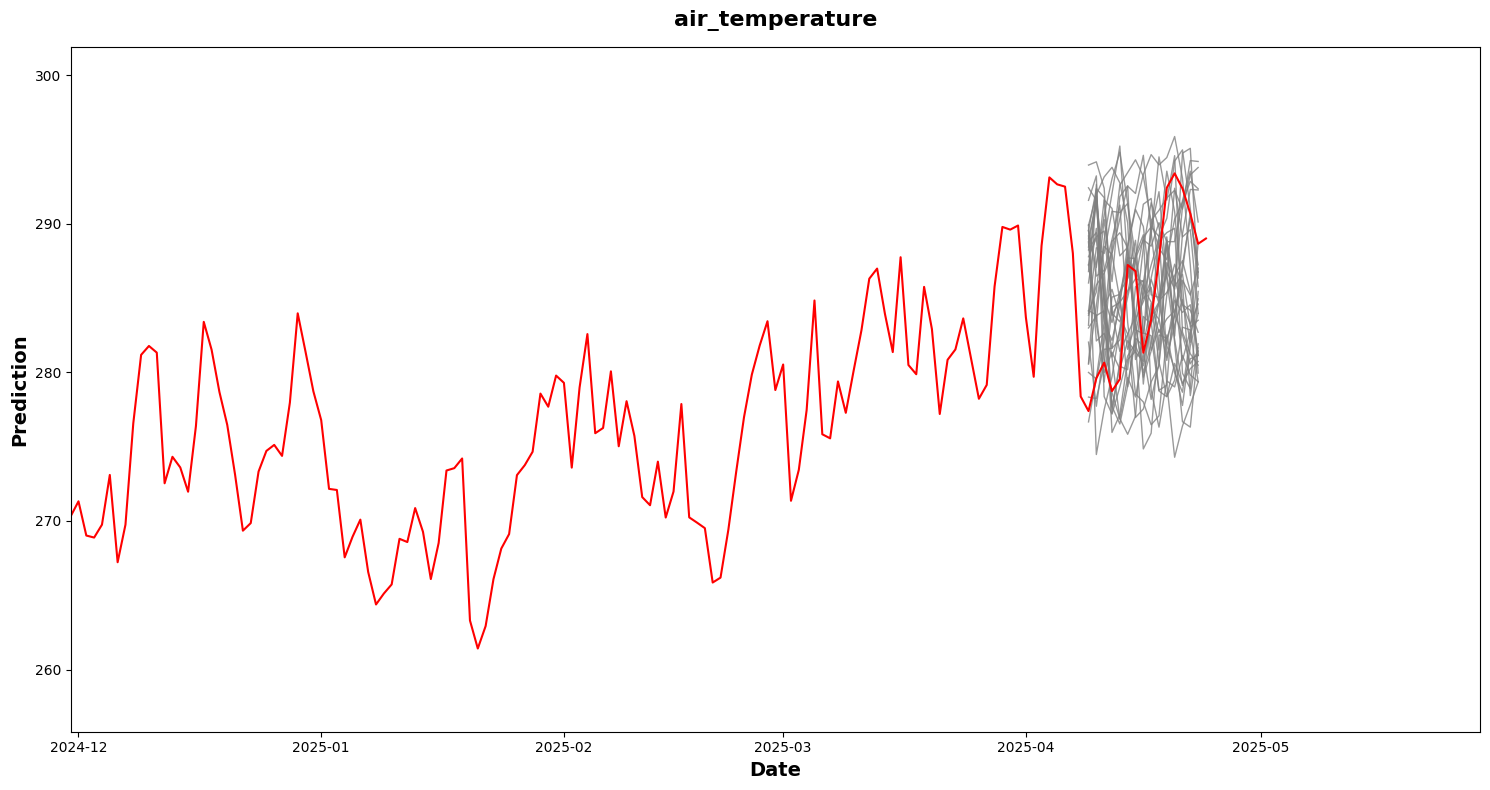

In [37]:

# --- Plotting Function ---
def plot_weather_comparison(historical_weather, future_weather, forecast_date, method='interpolate'):  # Add method parameter
    """
    Plots historical and future weather data.

    Args:
        historical_weather (pd.DataFrame): DataFrame containing historical weather data.
        future_weather (pd.DataFrame): DataFrame containing future weather data.
        forecast_date (datetime.date): The forecast date.
        method (str, optional): Method to handle missing values in future data.
                                 Can be 'interpolate' or 'drop'. Defaults to 'interpolate'.
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot future weather ensemble members
    for param in future_weather['parameter'].unique():
        subset = future_weather[future_weather['parameter'] == param]

        if method == 'interpolate':
            # Interpolate to handle missing values
            subset = subset.set_index('datetime').resample('D').asfreq()
            subset['air_temperature'] = subset['air_temperature'].interpolate(method='linear')
            subset = subset.reset_index()
        elif method == 'drop':
            # Drop rows with NaN values in 'air_temperature' before plotting
            subset = subset.dropna(subset=['air_temperature'])
        else:
            raise ValueError("Invalid method. Choose 'interpolate' or 'drop'.")


        ax.plot(subset['datetime'], subset['air_temperature'],
                color='gray', alpha=0.8, linewidth=1.0)

  # Rename 'prediction' to 'air_temperature' in historical_weather
    historical_weather = historical_weather.rename(columns={'prediction': 'air_temperature'})

    # Directly use 'air_temperature' for plotting (removed plot_col)
    historical_weather = historical_weather.dropna(subset=['air_temperature'])
    ax.plot(historical_weather['datetime'], historical_weather['air_temperature'],
            color='red', linewidth=1.5)
  # Formatting
    title = historical_weather['variable'].iloc[0] if 'variable' in historical_weather.columns else 'Air Temperature'
    ax.set_title(title, fontweight='bold', fontsize=16, pad=15)
    ax.set_xlim([forecast_date - timedelta(days=150), forecast_date + timedelta(days=30)]) # Change it to see the past date
    ax.grid(False)
    ax.set_ylabel('Prediction', fontweight='bold', fontsize=14)
    ax.set_xlabel('Date', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage with your DataFrames, choose method: 'interpolate' or 'drop'
plot_weather_comparison(historical_weather_df, future_weather_df, forecast_date, method='interpolate')  # Using 'interpolate' method

The next step is to convert our weather data to a wide format...**[explain why this is needed, what is the purpose of this step].**

In [38]:
def wide_format(df, index_cols):
    """Converts a DataFrame to wide format."""
    values_col = 'prediction' if 'prediction' in df.columns else 'air_temperature'
    # Convert Kelvin to Celsius if 'air_temperature' is the values column
    if values_col in ['air_temperature', 'prediction']:
        df[values_col] = df[values_col] - 273.15
    # Format datetime to date only
    df['datetime'] = pd.to_datetime(df['datetime']).dt.date

    df_wide = (
        df.pivot_table(
            index=index_cols,
            columns='variable',
            values=values_col,
            aggfunc='mean'
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    return df_wide

# --- Historical Weather Data (Wide Format) ---
historical_weather_wide = wide_format(historical_weather_df, ['datetime', 'site_id'])

# --- Future Weather Data (Wide Format) ---
future_weather_wide = wide_format(future_weather_df, ['datetime', 'site_id', 'parameter'])

print("Historical Weather:")
print(historical_weather_wide.head())

print("\nFuture Weather:")
print(future_weather_wide.head())

Historical Weather:
     datetime site_id  air_temperature
0  2020-10-01    fcre        13.832631
1  2020-10-02    fcre        11.998455
2  2020-10-03    fcre         9.862745
3  2020-10-04    fcre        11.033651
4  2020-10-05    fcre        12.197794

Future Weather:
     datetime site_id  parameter  air_temperature
0  2025-04-09    fcre        0.0        13.761762
1  2025-04-09    fcre        1.0        14.930836
2  2025-04-09    fcre        2.0        13.333738
3  2025-04-09    fcre        3.0        11.785780
4  2025-04-09    fcre        4.0         9.521020


Here, we will prepare our data for fitting our forecasting model. We will merge both air and water temperature into one dataframe.

In [39]:
# ————————————————————————————————————————————————
# Preparing data for Fitting the model
# ————————————————————————————————————————————————

# Ensure date-only columns
for df in (targets, historical_weather_df):
    df['datetime'] = pd.to_datetime(df['datetime']).dt.date

# Pivot targets to wide format (one column per variable)
targets_wide = (
    targets
    .pivot_table(
        index=['datetime', 'site_id', 'depth_m', 'duration'],
        columns='variable',
        values='observation',
        aggfunc='mean'
    )
    .reset_index()
)

# Merge in historical temperature and rename
targets_lm = (
    targets_wide
    .merge(
        historical_weather_df[['datetime', 'site_id', 'prediction']],
        on=['datetime', 'site_id'],
        how='left'
    )
    .rename(columns={'prediction': 'air_temperature'})
)

# Quick check
#print("Merged Data Structure:")
print(targets_lm.tail())


        datetime site_id  depth_m duration  Temp_C_mean  air_temperature
2393  2025-04-18    fcre      1.6      P1D    14.028957        14.464358
2394  2025-04-19    fcre      1.6      P1D    15.291631        19.274851
2395  2025-04-20    fcre      1.6      P1D    16.849979        20.240875
2396  2025-04-21    fcre      1.6      P1D    16.900887        19.225782
2397  2025-04-22    fcre      1.6      P1D    18.370816        17.528079


<ipython-input-39-82ce06a8d82e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime']).dt.date


Now we will conduct some forecast set-up and fit a linear regression model that uses air temperature to predict water temperature. We will set our `reference_datetime`, which is the date the forecast is generated, as well as our `forecast_horizon`, which is the maximum number of days into the future for which we will generate a forecast. The `forecast_dates` vector is all the dates in the forecast, from today until the maximum number of days specified by the `forecast_horizon`. Finally, we will fit our model.

Note that the model will be fit using air temperature values from the Stage 3 NOAA data product rather than observed air temperature values from Falling Creek Reservoir. Fitting the model with Stage 3 data ensures that the model is trained on data with similar statistical properties as the Stage 2 NOAA forecasts that we will use when we transition into forecasting mode.

In [43]:
# ————————————————————————————————————————————————
# 1. Forecast setup & linear model
# ————————————————————————————————————————————————
forecast_date   = datetime.today().date() # this was already defined once, does it need to be defined again?
forecast_horizon = 30
forecast_dates   = pd.date_range(start=forecast_date, periods=forecast_horizon)

# Prepare training data
train = targets_lm.dropna(subset=['air_temperature', 'Temp_C_mean'])
X_train = train[['air_temperature']].values
y_train = train['Temp_C_mean'].values

# Fit model
lin_model = LinearRegression().fit(X_train, y_train)
coef, intercept = lin_model.coef_[0], lin_model.intercept_
print(f"Linear Model: Temp_C = {coef:.2f} * AirTemp + {intercept:.2f}")


Linear Model: Temp_C = 0.78 * AirTemp + 5.22


At last, we generate a forecast! We use the future forecasted air temperature from NOAA to generate a 1-30-day-ahead forecast of water temperature using our fitted model from above.

Note that below, the forecast is generated using a for-loop. This is not actually needed for the regression model we are using today, but if we were using a model with an autoregressive term, we would need to use a for-loop so that the previous day's forecast could be used to generate the next day's forecast from 1-30 days into the future. Because many ecological forecasting models do have autoregressive terms, we have written the tutorial using a for-loop to better enable users to swap out the simple model here with a different model of their choosing.

In [45]:
# ————————————————————————————————————————————————
# 2. Generate 30‑day ensemble forecasts
# ————————————————————————————————————————————————
forecast_list = []
for ts in forecast_dates:
    date = ts.date()
    drivers = future_weather_wide[
        (future_weather_wide['datetime'] == date) &
        (future_weather_wide['site_id'] == 'fcre')
    ]
    if drivers.empty:
        continue

    preds = lin_model.predict(drivers[['air_temperature']].values)
    fc = drivers.assign(
        datetime           = date,
        reference_datetime = forecast_date,
        depth_m            = 1.6,
        variable           = 'Temp_C_mean',
        family             = 'ensemble',
        prediction         = preds,
        duration           = 'P1D',
        project_id         = 'vera4cast'
    )[
        ['datetime','reference_datetime','site_id','depth_m',
         'variable','family','parameter','prediction','duration','project_id']
    ]
    forecast_list.append(fc)

forecast_df = pd.concat(forecast_list, ignore_index=True)

#N = future_weather_wide['parameter'].nunique()
#print(f"Ensemble size: {N}")

Define a plotting function for the forecast, and then plot your forecast and revel in the glory of being a forecaster!

<ipython-input-46-c28686414802>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-46-c28686414802>:28: UserWarning: 
The palette list has fewer values (1) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


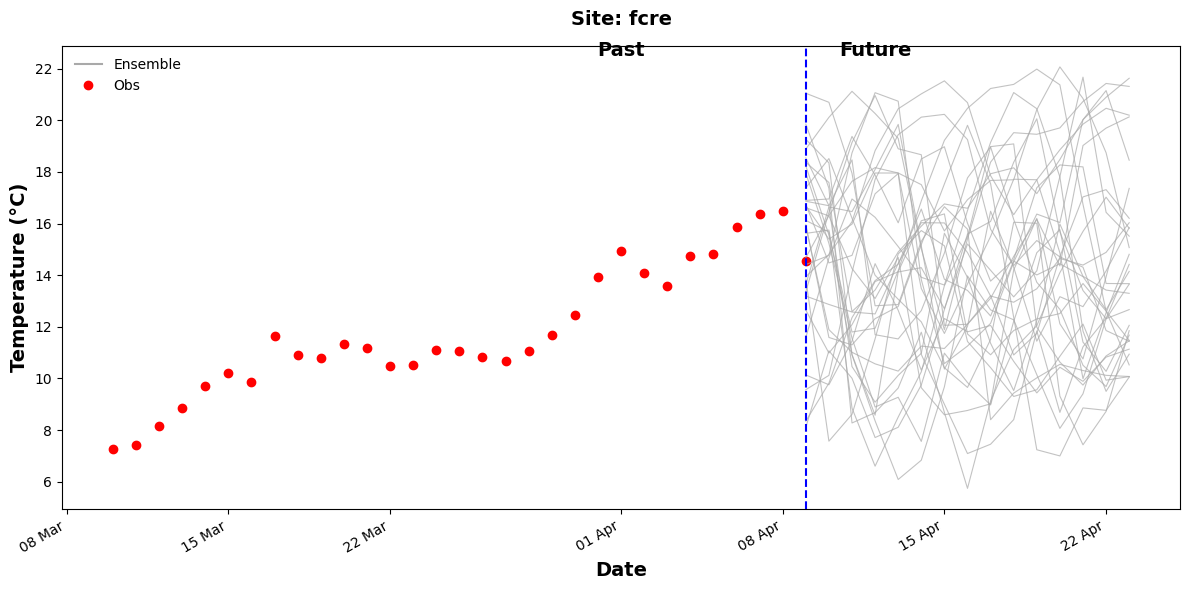

In [46]:
# ————————————————————————————————————————————————
# 3. Plotting function
# ————————————————————————————————————————————————
def plot_forecasts(historical, forecasts, target_obs, ref_date, site_id='fcre'):
    """
    Plots historical observations vs. ensemble forecasts.

    Parameters:
      historical : pd.DataFrame  (must have 'datetime' & 'prediction' columns)
      forecasts  : pd.DataFrame  (ensemble members with 'datetime','parameter','prediction')
      target_obs : pd.DataFrame  (observed 'observation' at matching dates)
      ref_date   : datetime.date  forecast origin date
      site_id    : str            site identifier (for title)
    """
    window_start = ref_date - timedelta(days=30)
    historical  = historical[
        (historical['datetime'] >= window_start) &
       (historical['datetime'] <= ref_date)
    ]
    # Convert 'datetime' column to datetime.date before comparison
    target_obs['datetime'] = pd.to_datetime(target_obs['datetime']).dt.date
    target_obs  = target_obs[
       (target_obs['datetime'] >= window_start) &
       (target_obs['datetime'] <= ref_date)
   ]

    fig, ax = plt.subplots(figsize=(12,6))
    sns.lineplot(
        data=forecasts,
        x='datetime', y='prediction', hue='parameter',
        palette=['darkgrey'], alpha=0.7, linewidth=0.8,
        legend=False, ax=ax, ci=None
    )
    ax.scatter(
        pd.to_datetime(target_obs['datetime']),
        target_obs['observation'],
        color='red', label='Observations'
    )
    ax.axvline(ref_date, color='blue', linestyle='--', linewidth=1.5)
    ax.text(ref_date - timedelta(days=8), target_obs['observation'].max()+6,
            "Past", ha='center',fontweight='bold',fontsize=14)
    ax.text(ref_date + timedelta(days=3), target_obs['observation'].max()+6,
            "Future", ha='center',fontweight='bold',fontsize=14)

    ax.set_title(f"Site: {site_id}", pad=15,fontweight='bold',fontsize=14)
    ax.set_xlabel("Date",fontweight='bold',fontsize=14)
    ax.set_ylabel("Temperature (°C)",fontweight='bold',fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    fig.autofmt_xdate()
    ax.grid(False)
    ax.legend(loc='upper left', frameon=False,
              handles=[
                  plt.Line2D([], [], color='darkgrey', label='Ensemble'),
                  plt.Line2D([], [], marker='o', color='red',
                             linestyle='None', label='Obs')
              ])
    plt.tight_layout()
    plt.show()

# ————————————————————————————————————————————————
# 4. plot
# ————————————————————————————————————————————————
forecast_temp = forecast_df[forecast_df['variable']=='Temp_C_mean']
obs = targets[
    (targets['depth_m']==1.6) &
    (targets['variable']=='Temp_C_mean')
]

plot_forecasts(
    historical=historical_weather_df.rename(columns={'prediction':'observation'})[ ['datetime','observation'] ],
    forecasts = forecast_temp,
    target_obs=obs,
    ref_date  = forecast_date
)

In order to submit your forecast to the VERA forecasting challenge, the forecast must be in a particular format this is described in detail here: https://www.ltreb-reservoirs.org/vera4cast/instructions.html#forecast-file-format.

Below, we conduct some data wrangling to properly format the forecast for submission.

Note that the `model_id` column is set to `example_ID`. Any forecast submitted with `example` in the `model_id` can be submitted to VERA without registering for the challenge; however, these example models will not show up on the forecast performance dashboard (https://www.ltreb-reservoirs.org/vera4cast/performance.html). This is to allow users to "play" with models until they have developed a final version that they are ready to register and submit for evaluation.

Once you have fine-tuned your forecast model and are ready to officially participate in the challenge, you should choose a `model_id` that does not include `example`. Then, when you try to submit the forecast, you will be prompted to register by filling out a Google Form. Once you have filled out the form, you will be able to submit your non-example model to the VERA forecasting challenge.



In [48]:
################################################################
# Oraganising/Formatting, and saving the files for model submission
###############################################################

model_id = 'example_ID'  # Change your model

# Directly modify the original forecast_df
forecast_df['model_id'] = model_id
forecast_df['reference_datetime'] = forecast_date
forecast_df['family'] = 'ensemble'
forecast_df['parameter'] = forecast_df['parameter'].astype(str)
forecast_df['duration'] = 'P1D'
forecast_df['depth_m'] = 1.6
forecast_df['project_id'] = 'vera4cast'

# Select the desired columns in the desired order
forecast_df_standard = forecast_df[[
    'datetime', 'reference_datetime', 'site_id', 'duration', 'family',
    'parameter', 'variable', 'prediction', 'depth_m', 'model_id', 'project_id'
]]

# Define the directory and file paths
save_here = '/content/Forecasts'  # Use '/content/' for Colab You can change to preferred path here
forecast_file = os.path.join(save_here, f"{forecast_date}-{model_id}.csv")

# Create directory if it doesn't exist
os.makedirs(save_here, exist_ok=True)
print(f"Directory '{save_here}' created or already exists.") # More concise message

# Write the forecast DataFrame to a CSV file
forecast_df_standard.to_csv(forecast_file, index=False)
print(f"Forecast saved to '{forecast_file}'.")

# Optional: Download the file (if you want to keep it after the session)
# from google.colab import files
# files.download(forecast_file)

Directory '/content/Forecasts' created or already exists.
Forecast saved to '/content/Forecasts/2025-04-09-example_ID.csv'.


The last step! We will use the custom `vera3castHelpers` R package to evaluate and submit our forecasts to the VERA forecasting challenge.

In [51]:
################################################################
# Validating and Submitting the model using R package
###############################################################

# Import the vera4castHelpers package
vera4castHelpers = importr('vera4castHelpers') # does this need to be called again since it was already called above?

# Validation of the file for the submission
ro.r(f"vera4castHelpers::forecast_output_validator(forecast_file = '{forecast_file}')")

# Submission 'Uncomment' to submit your Forecast

#ro.r(f"vera4castHelpers::submit(forecast_file = '{forecast_file}')") # I didn't get the confirmation message that it was submitted?

✔ file has model_id column
✔ forecasted variables found correct variable + prediction column
✔ file has correct family and parameter columns
✔ file has site_id column
✔ file has datetime column
✔ file has correct datetime column
✔ file has duration column
✔ file has depth column
✔ file has project_id column
✔ file has reference_datetime column


1


Below we provide some optional code for you to explore the model fit of the example linear regression model that we have just submitted to the VERA forecasting challenge. Of course, there are likely many alternative model structures that could provide a better forecast of future water temperatures! At the end of this tutorial, you'll find some thought questions to help you get started in developing your own model to submit to the VERA forecasting challenge. Happy forecasting!

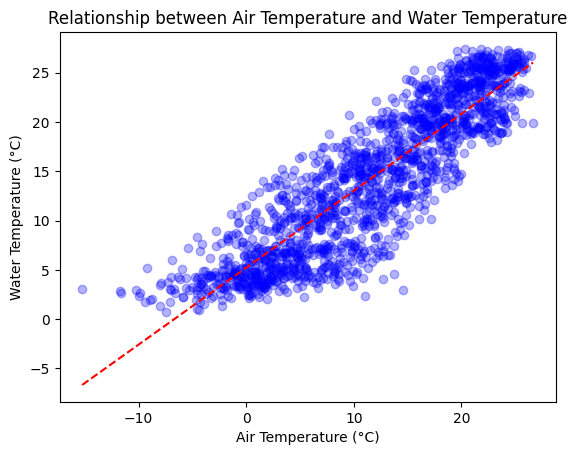

In [ ]:
# Exporting the 'targets_lm' dataframe
x = targets_lm['air_temperature']
y = targets_lm['Temp_C_mean']

# Choose the color for the dots (e.g., 'blue', 'green', '#FF5733', etc.)
dot_color = 'blue'

# Remove rows with NaN values in 'air_temperature' and 'Temp_C_mean'
valid_data = targets_lm.dropna(subset=['air_temperature', 'Temp_C_mean'])
x = valid_data['air_temperature']
y = valid_data['Temp_C_mean']

# Create the scatter plot
plt.scatter(x, y, color=dot_color, alpha=0.3)

# Fit the linear regression model
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)  # Reshape x for sklearn

# Get the regression line coordinates
x_line = np.linspace(x.min(), x.max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))

# Calculate R-squared
r_squared = r2_score(y, model.predict(x.values.reshape(-1, 1)))

# Plot the regression line (adjust color and linestyle as needed)
plt.plot(x_line, y_line, color='red', linestyle='--')

# Add labels and title
plt.title('Relationship between Air Temperature and Water Temperature')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Water Temperature (°C)')

# Add legend to display R-squared
#plt.legend()

# Show the plot
plt.show()

Can we add some thought questions here (maybe even the same ones from the R tutorial) to get people started?